In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn
import numpy as np
import pandas as pd

In [2]:
train_data = pd.read_csv('../data/kaggle_house_pred_train.csv')
test_data = pd.read_csv('../data/kaggle_house_pred_test.csv')

In [3]:
train_data.shape

(1460, 81)

In [4]:

test_data.shape

(1459, 80)

In [5]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [6]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
# 去掉id和去掉SalePrice

In [7]:
# 标准化
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后，每个特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [8]:
# https://blog.csdn.net/maymay_/article/details/80198468
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [9]:
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1, 1))

In [10]:

loss = gloss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

In [11]:
def log_rmse(net, features, labels):
    # 将小于1的值设成1，使得取对数时数值更稳定
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.asscalar()

In [12]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [13]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

In [14]:
# 实验
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f'
              % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

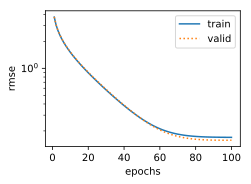

fold 0, train rmse 0.169534, valid rmse 0.157394
fold 1, train rmse 0.162262, valid rmse 0.188740
fold 2, train rmse 0.163577, valid rmse 0.167843
fold 3, train rmse 0.167480, valid rmse 0.154459
fold 4, train rmse 0.162894, valid rmse 0.182810
5-fold validation: avg train rmse 0.165149, avg valid rmse 0.170249


In [15]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f'
      % (k, train_l, valid_l))

In [16]:
# 实际
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).asnumpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0]) # # Series是一个一维的数据结构
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

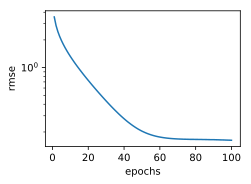

train rmse 0.162554


In [17]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)